# Investigating the External Potential Energy Surface

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from graphenetools import gt
import re,glob,os
from scipy.signal import argrelextrema
from scipy.optimize import brentq
import multiprocessing 
import sys,importlib
from dgutils import colors as colortools
from collections import defaultdict
import pickle
from numpy import pi as π

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# plot style
plot_style = {'notebook':'../include/notebook.mplstyle','aps':'../include/aps.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['aps'])
figsize = plt.rcParams['figure.figsize']
plt.rcParams['text.latex.preamble'] = f'\input{{{os.getcwd()}/../include/texheader}}'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Do you want to process the full data set?

Default is False. The full data set can be found here: 

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.4553524.svg)](https://doi.org/10.5281/zenodo.4553524)

In [2]:
reduce_data = False

## Some helper and analysis functions

In [3]:
import layerutils
importlib.reload(layerutils)
from layerutils import lab,vals,texformat

# get the graphene lattice information
Am, An, b1, b2, gm, gn = gt.get_graphene_vectors(0.0)

## Analyzing the QMC Data

In [4]:
pimcid = {}
pimcid[lab(n=0,Lz=10.0,N=24,T=0)] ='f30888e2-236f-4f50-a8ea-d3fee58f74f2t'

simulations = list(pimcid.keys())

skip = {sim:0 for sim in simulations}

# Set this to your a bash variable ($HeGrapheneData here) or the hardcoded directory where you have downloaded and extracted the simulation data
data_dir = os.environ["HeGrapheneData"]
base_dir = {sim:f'{data_dir}/N_eq_{vals(sim)["N"]:03d}/PIGS/' for sim in simulations}

## Extract some details from the simulation log file

### Note on using pimchelp

For now, `pimchelp` help is a script that can be downloaded from our [github repository](https://github.com/DelMaestroGroup/pimcscripts). You will need to add its location to your python path which I have set as a bash variable called `$SCDIR` here.

In [5]:
script_dir = os.environ["SCDIR"]
sys.path.append(script_dir)

import pimchelp
importlib.reload(pimchelp)

<module 'pimchelp' from '/Users/agdelma/local/src/pimcscripts/pimchelp.py'>

In [6]:
par_map,file_name = {},{}

for sim in simulations:
    file_name[sim] = pimchelp.get_estimator_names(base_dir[sim],pimcid[sim])
    par_map[sim] = pimchelp.getParameterMap(file_name[sim]['log'])

L,μ,n,N,τ,N_ads = {},{},{},{},{},{}

for sim in simulations:
    # We add some short-hand variables for ease of referencing
    L[sim] = np.array(par_map[sim]['Container Dimensions'])
    n[sim] = par_map[sim]['Initial Density']
    N[sim] = par_map[sim]['Initial Number Particles']
    τ[sim] = par_map[sim]['Specified Imaginary Time Step']
    μ[sim] = par_map[sim]['Chemical Potential']

## Visualize the Simulation Cell

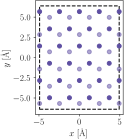

In [7]:
for sim in simulations:
    fix,ax = gt.plot_graphene_lattice(0.0,L[sim][:-1])

### Check convergence of QMC data

In [ ]:
if reduce_data:
    est_names = ' '.join([f'-l "{texformat(sim, split_lines=True)}" {file_name[sim]["estimator"]}' for sim in simulations]);
    %run $script_dir/pimcplot.py -e V_ext $est_names
    %run $script_dir/plotbin.py {file_name[sim]["estimator"]} -e E

In [7]:
for sim in simulations:
    print('\n',sim)
    %run $script_dir/pimcave.py {file_name[sim]['estimator']}


 T = 0.00 K, Lz = 10.00 Å, N = 024, n = 0
# PIMCID 30888e2-236f-4f50-a8ea-d3fee58f74f2
# Number Samples 1062124
K                   22.86419	     0.00865	 0.04
V                 -145.84303	     0.00167	 0.00
V_ext             -145.80389	     0.00167	 0.00
V_int                0.00000	     0.00000	 0.00
E                 -122.97884	     0.00845	 0.01
E_mu              -122.97884	     0.00845	 0.01
K/N                 22.86419	     0.00865	 0.04
V/N               -145.84303	     0.00167	 0.00
E/N               -122.97884	     0.00845	 0.01


<Figure size 245.081x151.469 with 0 Axes>

## Linear Density

In [9]:
if reduce_data:
    for sim in simulations:
        if 'grand' in par_map[sim]['Ensemble']:
            %run $script_dir/reduce-one.py -r T -L {L[sim][2]} -u {μ[sim]} -t {τ[sim]} -s {skip[sim]} -i {pimcid[sim]} --estimator=lineardensity  {base_dir[sim]}/
        else:
            %run $script_dir/reduce-one.py -r T -N {N[sim]} -n {n[sim]} -t {τ[sim]} -s {skip[sim]} -i {pimcid[sim]} --canonical --estimator=lineardensity  {base_dir[sim]}/

In [7]:
ρ_lin,δρ_lin = {},{}
z_lin = {}
ave_N = {}
for sim in simulations:
    reduce_params = {'canonical':('canonical' == par_map[sim]['Ensemble']),'L':L[sim][2],'μ':μ[sim],'τ':τ[sim],'N':N[sim],'n':n[sim],
                    'pimcid':pimcid[sim],'base_dir':base_dir[sim],'reduce':'T'}

    z_lin[sim],ρ_lin[sim],δρ_lin[sim] = np.loadtxt(
        pimchelp.get_reduce_name(estimator='lineardensity',**reduce_params),unpack=True)

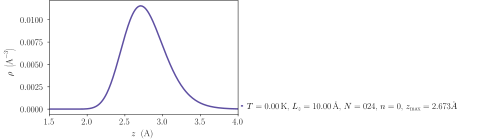

In [8]:
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
fig,ax = plt.subplots()
for sim in simulations:
    first_layer_id = np.argmax(ρ_lin[sim])
    z_max = z_lin[sim][first_layer_id]+L[sim][2]/2
    _z,_y = z_lin[sim]+L[sim][2]/2,ρ_lin[sim]
    spl = interpolate.interp1d(_z, _y, kind='cubic')
    _z = np.linspace(0,9,1000)
    #spl.set_smoothing_factor(4)
    ax.plot(_z,spl(_z), label=texformat(sim) + f', $z_\mathrm{{max}} = {z_max:.3f} Å$')

    #print(z_max)

    #plt.plot(ρ_lin[id(1/3,40)][:,0]+L[id(1/3,40)][2]/2,ρ_lin[id(1/3,40)][:,1], label=f'$\mu = {μ[id(1/3,40)]}\ \mathrm{{K}}$')

#print(z[fill][np.argmax(ρz[fill])]+L[fill][2]/2)
#plt.text(0.99,0.9,f'$z_\mathrm{{max}} = {z_max:.3f} Å$', fontsize=18,transform=ax.transAxes, ha='right')
ax.set_xlim(1.5,4)
ax.set_xlabel(r'$\alabel{z}{\angstrom}$')
ax.set_ylabel(r'$\alabel{\rho}{\angstrom^{-3}}$')
ax.legend(loc=(1,0))
#plt.savefig('./plots/rho_z_first_layer.png',dpi=300, facecolor='white')

### Check Normalization

In [9]:
np.sum(spl(_z))*(_z[1]-_z[0])*L[sim][0]*L[sim][1]

0.9999999033506463

### Determine how the bare potential is effected by this profile

In [10]:
from scipy.integrate import simps
aₒ = 1.42
σ,ε = gt.get_LJ_parameters(0.0)

# Helium-Graphene Potential
V_HeG = np.vectorize(gt.V_64)
sim = lab(n=0,Lz=10.0,N=24,T=0)
_z,_y = z_lin[sim][1:]+L[sim][2]/2,ρ_lin[sim][1:]*L[sim][0]*L[sim][1]

Vmin = simps(V_HeG(0.0,σ,ε,0,0,_z)*_y,_z)
Vmax = simps(V_HeG(0.0,σ,ε,b1[0],b1[1],_z)*_y,_z)
Vsp = simps(V_HeG(0.0,σ,ε,Am[0]/2,Am[1]/2,_z)*_y,_z)

print(f'Vmin = {Vmin:.2f} K')
print(f'Vmax-Vmin = {Vmax-Vmin:.2f} K')
print(f'Vsp-Vmmin = {Vsp-Vmin:.2f} K')

Vmin = -159.48 K
Vmax-Vmin = 32.55 K
Vsp-Vmmin = 26.16 K


## Planar Density

In [11]:
match_number = re.compile('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *-?\ *[0-9]+)?')
δ_xy,num_grid_xy = {},{}
ρxy = {}
x_2D,y_2D = {},{}
for sim in simulations:
    try:
        with open(file_name[sim]['planeavedensity'],'r') as inFile:
            est_info = inFile.readline()
            #est_info = inFile.readline()
            print(est_info)
            nums = [x for x in re.findall(match_number, est_info)]
            δ_xy[sim] = np.array([float(num) for num in nums[:2]])
            num_grid_xy[sim] = int(nums[-1])
            
        ρxy[sim] = np.loadtxt(file_name[sim]['planeavedensity']).reshape([num_grid_xy[sim],num_grid_xy[sim]])
        
       
        x_2D[sim] = np.arange(-L[sim][0]*0.5,L[sim][0]*0.5-0.001,δ_xy[sim][0])
        y_2D[sim] = np.arange(-L[sim][1]*0.5,L[sim][1]*0.5-0.001,δ_xy[sim][0])
    except:
        print(f'{sim}: Could not load file!')

# ESTINF: dx = 4.799048E-02 dy = 6.234146E-02 NGRIDSEP = 205



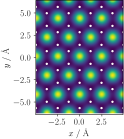

In [12]:
figsize = plt.rcParams['figure.figsize']
fig,ax = plt.subplots(nrows=1,ncols=len(simulations),sharex=True, sharey=True,figsize=(len(simulations)/2*figsize[0],figsize[1]),squeeze=False)
fig.subplots_adjust(wspace=0.1)
c_positions = {}
for i,sim in enumerate(simulations):
    
    c_positions[sim] = np.vstack(gt.get_graphene_carbon_atoms(0.0,L[sim][:-1]))

    ax[0,i].scatter(c_positions[sim][:,0], c_positions[sim][:,1], s=2, c='w')
    ax[0,i].imshow(ρxy[sim].T,aspect='equal',extent=[np.min(x_2D[sim]),np.max(x_2D[sim]),np.min(y_2D[sim]),np.max(y_2D[sim])],
                   cmap='viridis', rasterized=True)
#     ax[0,i].annotate(texformat(sim,split_lines=True), xy=(0.05,0.9),xytext=(0.05, 0.9), 
#                    textcoords='axes fraction', color='white', va='top',fontsize=18)

    ax[0,i].set_xlabel(r'$x\;/\;\mathrm{\AA}$')

ax[0,0].set_ylabel(r'$y\;/\;\mathrm{\AA}$');
#plt.savefig('./plots/isotropic_graphene_density.png', dpi=300, facecolor='white')

## External Potential Energy in the Plane

In [13]:
match_number = re.compile('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *-?\ *[0-9]+)?')
δ_xy,num_grid_xy = {},{}
Vext_xy = {}
x_2D,y_2D = {},{}
for sim in simulations:
    try:
        with open(file_name[sim]['planeaveVext'],'r') as inFile:
            est_info = inFile.readline()
            print(est_info)
            nums = [x for x in re.findall(match_number, est_info)]
            δ_xy[sim] = np.array([float(num) for num in nums[:2]])
            num_grid_xy[sim] = int(nums[-1])
            
        Vext_xy[sim] = np.loadtxt(file_name[sim]['planeaveVext']).reshape([num_grid_xy[sim],num_grid_xy[sim]])
        
       
        x_2D[sim] = np.arange(-L[sim][0]*0.5,L[sim][0]*0.5-0.001,δ_xy[sim][0])
        y_2D[sim] = np.arange(-L[sim][1]*0.5,L[sim][1]*0.5-0.001,δ_xy[sim][0])
    except:
        print(f'{sim}: Could not load file!')

# ESTINF: dx = 4.799048E-02 dy = 6.234146E-02 NGRIDSEP = 205



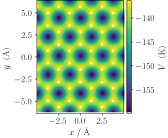

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

figsize = plt.rcParams['figure.figsize']
fig,ax = plt.subplots(nrows=1,ncols=len(simulations),sharex=True, sharey=True,figsize=(len(simulations)/2*figsize[0],figsize[1]),squeeze=False)
fig.subplots_adjust(wspace=0.1)
for i,sim in enumerate(simulations):

    ax[0,i].scatter(c_positions[sim][:,0], c_positions[sim][:,1], s=2, c='w')
    im = ax[0,i].imshow(Vext_xy[sim].T,aspect='equal',extent=[np.min(x_2D[sim]),np.max(x_2D[sim]),np.min(y_2D[sim]),np.max(y_2D[sim])],cmap='viridis', 
                        rasterized=True)
#     ax[0,i].annotate(texformat(sim,split_lines=True), xy=(0.05,0.9),xytext=(0.05, 0.9), 
#                    textcoords='axes fraction', color='white', va='top',fontsize=18)

    ax[0,i].set_xlabel(r'$x\;/\;\mathrm{\AA}$')

ax[0,0].set_ylabel(r'$\alabel{y}{\angstrom}$') #r'$y\;/\;\mathrm{\AA}$');

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax[0,-1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax, label=r'$\alabel{V}{\kelvin}$')

#plt.savefig('../plots/isotropic_graphene_density.png', dpi=300, facecolor='white')

### Analyze the Max/Min/Saddlepoint values

In [15]:
Vsp_qmc = {}
Vmin_qmc = {}
Vmax_qmc = {}
for sim in simulations:
    Vmax_qmc[sim] = np.max(Vext_xy[sim])
    Vmin_qmc[sim] = np.min(Vext_xy[sim])
    Vsp_qmc[sim] = np.min(Vext_xy[sim].T[102,np.where(x_2D[sim]<=0.5*Am[0])[0][-1]])
    
    print(f'Vmin = {Vmin_qmc[sim]:.2f} K')
    print(f'Vmax-Vmin = {Vmax_qmc[sim]-Vmin_qmc[sim]:.2f} K')
    print(f'Vsp-Vmmin = {Vsp_qmc[sim]-Vmin_qmc[sim]:.2f} K')

Vmin = -159.96 K
Vmax-Vmin = 23.58 K
Vsp-Vmmin = 20.53 K


### Compare with those found above

In [16]:
for sim in simulations:
    print(f'rel Vmin = {Vmin_qmc[sim]/Vmin:.2f} K')
    print(f'rel Vmax_Vmin = {(Vmax_qmc[sim]-Vmin_qmc[sim])/(Vmax-Vmin):.2f} K')
    print(f'rel Vsp-Vmmin = {(Vsp_qmc[sim]-Vmin_qmc[sim])/(Vsp-Vmin):.2f} K')

rel Vmin = 1.00 K
rel Vmax_Vmin = 0.72 K
rel Vsp-Vmmin = 0.78 K


## Combine Everything into a Single Plot

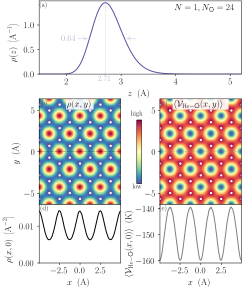

In [17]:
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import matplotlib.patheffects as path_effects


from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import ticker

figsize = plt.rcParams['figure.figsize']

width = [1,1]
height = [1.25,2.5,1]
fig = plt.figure(constrained_layout=True, figsize=(figsize[0],1.9*figsize[1]))
gs = fig.add_gridspec(3,2,width_ratios=width, height_ratios=height)
ax = [fig.add_subplot(gs[0,:]),fig.add_subplot(gs[1,0]),fig.add_subplot(gs[1,1]),
      fig.add_subplot(gs[2,0]),fig.add_subplot(gs[2,1])]

light_purple = '#afa7d0'

from scipy import interpolate
for sim in simulations:
    
    # ---------------------------------------------------------
    # ρ(z)    
    # ---------------------------------------------------------
    
    _z,_y = z_lin[sim]+L[sim][2]/2,ρ_lin[sim]
    spl = interpolate.interp1d(_z, _y, kind='cubic')
    _z = np.linspace(0,9,1000)
    
    first_layer_id = np.argmax(spl(_z))
    z_max = _z[first_layer_id]
    
    half_max = 0.5*np.max(spl(_z))
    half_max_idx = np.where(np.abs(spl(_z)-half_max)<0.0001)[0]
    
    half_max *= L[sim][0]*L[sim][1]
    ax[0].plot(_z,spl(_z)*L[sim][0]*L[sim][1], lw=1)
    ax[0].plot([z_max,z_max],[0.00,np.max(spl(_z)*L[sim][0]*L[sim][1])], ls=':',color=light_purple, lw=0.5)
    
    xmin,xmax=_z[half_max_idx[0]],_z[half_max_idx[1]]
    #ax[0].plot([z_max,xmax],[half_max,half_max], ls='--',color=colors[0], lw=0.5)
    #ax[0].text(z_max+0.018,half_max+0.0011,f'{(xmax-xmin)/2:.2f}', fontsize=8, 
    #           ha='left',va='top', color=colors[0])
    
    # FWHM arrows
    ax[0].annotate("",
            xy=(xmax,half_max), xycoords='data',
            xytext=(xmax+0.25, half_max), textcoords='data',
            arrowprops=dict(arrowstyle="->", ls=':',lw=0.5,
                            connectionstyle="arc3",ec=light_purple,zorder=-10),
            )
    ax[0].annotate("",
            xy=(xmin,half_max), xycoords='data',
            xytext=(xmin-0.25, half_max), textcoords='data',
            arrowprops=dict(arrowstyle="->", ls=':',lw=0.5,
                            connectionstyle="arc3",ec=light_purple,zorder=-10),
            )
    ax[0].annotate(f'{(xmax-xmin):.2f}',
            xy=(xmin-0.25, half_max), xycoords='data',
            xytext=(-15, -2.5), textcoords='offset points', color=light_purple,zorder=-10
            )

    ax[0].set_xlim(1.5,5.2)
    ax[0].set_xlabel(r'$\alabel{z}{\angstrom}$')
    ax[0].set_ylabel(r'$\alabel{\rho(z)}{\angstrom^{-1}}$')
    ax[0].text(0,0.99,'(a)', fontsize=7, ha='left',va='top',
              transform=ax[0].transAxes)
    ax[0].text(z_max,-0.025,f'{z_max:.2f}', fontsize=8, ha='center',va='top', color=light_purple)
    ax[0].text(0.985,0.96,r'$N = 1, N_\graphene = 24$', fontsize=9, ha='right',va='top',
              transform=ax[0].transAxes)

    ax[0].set_ylim(0,1.49)
    
    # ---------------------------------------------------------
    # ρ(x,y)    
    # ---------------------------------------------------------
    extent=[np.min(x_2D[sim]),np.max(x_2D[sim]),np.min(y_2D[sim]),np.max(y_2D[sim])]
    ax[1].scatter(c_positions[sim][:,0], c_positions[sim][:,1], s=2, c='w')
    im = ax[1].imshow(ρxy[sim].T,extent=extent,cmap='Spectral_r', rasterized=True, 
                interpolation='none')

    ax[1].axhline(y=0, lw=0.5,color='k', ls=':')
    ax[1].set_ylabel(r'$\alabel{y}{\angstrom}$')
    ax[1].set_xticks([])
    ax[1].text(0.5,0.99,r'$\rho(x,y)$', fontsize=9, ha='center',va='top',
              transform=ax[1].transAxes, 
               bbox=dict(facecolor='w',alpha=0.9, pad=0.75, edgecolor='None'))
    ax[1].text(0,0.99,'(b)', fontsize=7, ha='left',va='top',
              transform=ax[1].transAxes,
               path_effects=[path_effects.withSimplePatchShadow(offset=(0.04, -0.04), shadow_rgbFace='white', alpha=1.0)])
    ax[1].yaxis.set_major_locator(ticker.MultipleLocator(5))
    
    custom_lines = [Line2D([0],[0],color='#4968b1', lw=5),
                    Line2D([0],[0],color='#cd314b', lw=5)]
    #fig.legend(custom_lines,['low','high'],loc=(0.535,0.432), handlelength=0.01, 
     #           fontsize=8)
    
    #fig.colorbar(im, ax=ax[1], shrink=0.6)
    
    axins1 = inset_axes(ax[1],
                    width="6%",  # width = 50% of parent_bbox width
                    height="60%",  # height : 5%
                    loc='upper center',
                    bbox_to_anchor=(0.73, -0.2, 1, 1),
                   bbox_transform=ax[1].transAxes,
                   borderpad=0)
    cb = fig.colorbar(im, cax=axins1, ticks=[])
    fig.text(0.57, 0.353, 'low', horizontalalignment='center',
             verticalalignment='center', fontsize=7)
    fig.text(0.57, 0.607, 'high', horizontalalignment='center',
             verticalalignment='center', fontsize=7)

    
    # ---------------------------------------------------------
    # V_ext(x,y)    
    # ---------------------------------------------------------
    extent=[np.min(x_2D[sim]),np.max(x_2D[sim]),np.min(y_2D[sim]),np.max(y_2D[sim])]
    ax[2].scatter(c_positions[sim][:,0], c_positions[sim][:,1], s=2, c='w')
    im = ax[2].imshow(Vext_xy[sim].T,aspect='equal',extent=extent,cmap='Spectral_r', 
                        rasterized=True, interpolation='none')

    ax[2].axhline(y=0, lw=0.5,color='gray', ls=':')
    ax[2].set_xticks([])
    ax[2].text(0.5,0.99,r'$\expval{\mathcal{V}_{\rm He-\graphene}(x,y)}$', fontsize=9, ha='center',va='top',
              transform=ax[2].transAxes,
               bbox=dict(facecolor='w',alpha=0.9, pad=0.75, edgecolor='None'))
    ax[2].text(0,0.99,'(c)', fontsize=7, ha='left',va='top',
              transform=ax[2].transAxes, 
               path_effects=[path_effects.withSimplePatchShadow(offset=(0.04, -0.04), shadow_rgbFace='white', alpha=1)])
    ax[2].yaxis.set_major_locator(ticker.MultipleLocator(5))

 
    # ---------------------------------------------------------
    # ρ(x,y=0)    
    # ---------------------------------------------------------
    ax[3].plot(x_2D[sim],ρxy[sim].T[102,:]*L[sim][-1],color='k', lw=1)
    ax[3].set_ylabel(r'$\alabel{\rho(x,0)}{\angstrom^{-2}}$')
    ax[3].set_xlabel(r'$\alabel{x}{\angstrom}$')
    ax[3].set_xlim(x_2D[sim][0],x_2D[sim][-1])
    ax[3].text(0.01,0.99,'(d)', fontsize=7, ha='left',va='top',
              transform=ax[3].transAxes)
    ax[3].set_ylim(0,0.0159)
    
    # ---------------------------------------------------------
    # V_ext (x,y=0)    
    # ---------------------------------------------------------
    ax[4].plot(x_2D[sim],Vext_xy[sim].T[102,:],color='gray', lw=1)
    ax[4].set_ylabel(r'$\!\!\!\alabel{\expval{\mathcal{V}_{\rm He-\graphene}(x,0)}}{\kelvin}$')
    ax[4].set_xlabel(r'$\alabel{x}{\angstrom}$')
    ax[4].yaxis.set_label_coords(-0.325,0.38)
    ax[4].set_xlim(x_2D[sim][0],x_2D[sim][-1])
    ax[4].text(-0.01,0.99,'(e)', fontsize=7, ha='left',va='top',
              transform=ax[4].transAxes)
    
fig.set_constrained_layout_pads(w_pad=2/72, h_pad=0, hspace=-0.215, wspace=0)    
plt.savefig('../plots/N_eq_1_density.pdf')
plt.savefig('../plots/N_eq_1_density.svg')

### Volume

In [18]:
np.product(L[sim])

1257.3027900000002